Links:
* [How to Use Word Embedding Layers for Deep Learning with Keras](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)
* [What Are Word Embeddings for Text?](https://machinelearningmastery.com/what-are-word-embeddings/)
* [How to Develop a Word Embedding Model for Predicting Movie Review Sentiment
](https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/)
* [Embed, encode, attend, predict: The new deep learning formula for state-of-the-art NLP models](https://explosion.ai/blog/deep-learning-formula-nlp)
* [How to Develop Word Embeddings in Python with Gensim](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Input, Dense, Embedding, Flatten, Dropout
from keras.models import Model, Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
import seaborn as sn
from time import time
%matplotlib inline

Using TensorFlow backend.


In [2]:
def create_encoder_decoder(all_text):
    chars = sorted(set(all_text))
    char_to_int = dict((c, i + 1) for i, c in enumerate(chars))
    int_to_char = dict((i + 1, c) for i, c in enumerate(chars))
    return char_to_int, int_to_char

def encode_string(line, char_to_int, l):
    z = np.zeros(l)
    z[0:len(line)] = [char_to_int[c] for c in line]
    return z

def encode_strings(lines, char_to_int, l):
    return np.array([encode_string(line, char_to_int, l) for line in lines])

In [3]:
# Dataset
categories = ['Democrat', 'Republican']
tweetsdf = pd.read_csv('democratvsrepublicantweets/ExtractedTweets.csv')
handlesdf = pd.read_csv('democratvsrepublicantweets/TwitterHandles.csv')
raw_tweets = tweetsdf['Tweet']
normalized_tweets = raw_tweets.str.upper()
char_to_int, int_to_char = create_encoder_decoder(normalized_tweets.str.cat())
parties = tweetsdf['Party']
y = 1.0 - np.asarray(parties == 'Democrat')
max_tweet_len = normalized_tweets.str.len().max()
X = encode_strings(normalized_tweets, char_to_int, max_tweet_len)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
def model1():
    input = Input(shape=(max_tweet_len,1))
    x = Conv1D(256, kernel_size=4, activation='relu')(input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(64, kernel_size=4, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(32, kernel_size=4, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(input, x)
    optimizer = Adam(lr=0.0003)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return 'cnn-weights-0.0337.hdf5', model

In [7]:
model.load_weights('baseline-weights-0.0900-sm.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 166, 1)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 163, 256)          1280      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 81, 256)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 78, 64)            65600     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 39, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 36, 32)            8224      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 18, 32)            0         
__________

In [8]:
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
# tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
# callbacks_list = [checkpoint, tensorboard]
# model.fit(X_train, 
#           np_utils.to_categorical(y_train), 
#           epochs=100, 
#           batch_size=1000, 
#           callbacks=callbacks_list)

In [15]:
predictions = np.argmax(model.predict(np.reshape(X_test, (17292, 166, 1))), axis=1)

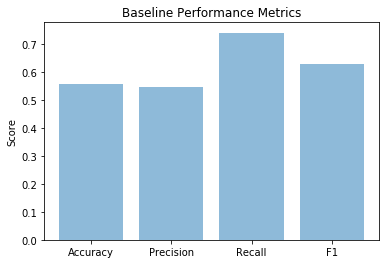

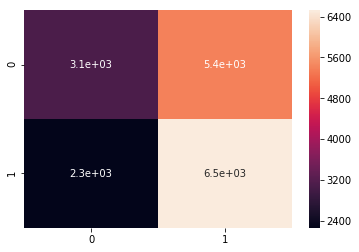

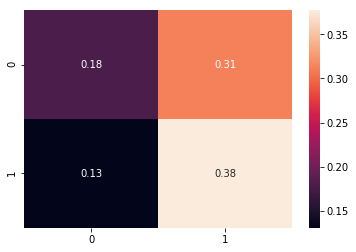

In [26]:
objects = ('Accuracy', 'Precision', 'Recall', 'F1')
y_pos = np.arange(len(objects))
performance = [accuracy_score(y_test, predictions), 
               precision_score(y_test, predictions), 
               recall_score(y_test, predictions), 
               f1_score(y_test, predictions)]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Score')
plt.title('Baseline Performance Metrics')

plt.show()

sn.heatmap(confusion_matrix(y_test, predictions), annot=True)

plt.show()

cm = confusion_matrix(y_test, predictions)
sn.heatmap(cm / cm.sum(), annot=True)

plt.show()